# Chapter 11: Portfolio Optimization and the Efficient Frontier

Portfolio optimization is the process of selecting the best portfolio allocation according to specific objectives, typically maximizing return for a given level of risk. This chapter provides practical tools for constructing optimal portfolios using real market data.

### Key Concepts We'll Cover:
- Efficient Frontier visualization
- Risk-return tradeoff analysis
- Portfolio optimization techniques
- Practical implementation with Python

*First, we need to set up the Tiingo API and define the tickers and date range for which we want to retrieve historical data:*

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tiingo import TiingoClient

# Configure Tiingo API
config = {
    'session': True,
    'api_key': os.getenv('TIINGO_API_KEY', 'YOUR KEY HERE')
}
client = TiingoClient(config)

# Define assets and time period
tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "META", "TSLA", "NVDA", "PYPL", "JPM",
           "BAC", "WMT", "DIS", "XOM", "CVX", "UNH", "JNJ", "V", "MA", "PG", "HD"]
start_date = "2023-01-01"
end_date = "2024-07-24"

print(f"Analyzing {len(tickers)} assets from {start_date} to {end_date}")

Analyzing 20 assets from 2023-01-01 to 2024-07-24


### 11.1 Data Retrieval and Preparation

In [2]:
def get_historical_data(tickers, start_date, end_date):
    """Fetch and validate historical price data"""
    try:
        data = client.get_dataframe(tickers, 
                                  metric_name='adjClose',
                                  startDate=start_date,
                                  endDate=end_date,
                                  frequency='daily')
        print(f"Successfully retrieved data for {len(data.columns)} assets")
        return data
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return None

# Fetch and inspect data
price_data = get_historical_data(tickers, start_date, end_date)
print("\nSample price data:")
print(price_data.head(3))

Successfully retrieved data for 20 assets

Sample price data:
                                 AAPL      GOOGL        MSFT   AMZN  \
2023-01-03 00:00:00+00:00  123.636303  88.690502  235.255908  85.82   
2023-01-04 00:00:00+00:00  124.911516  87.655514  224.965058  85.14   
2023-01-05 00:00:00+00:00  123.586876  85.784575  218.297608  83.12   

                                 META    TSLA       NVDA   PYPL         JPM  \
2023-01-03 00:00:00+00:00  124.160004  108.10  14.303297  74.58  126.659865   
2023-01-04 00:00:00+00:00  126.777775  113.64  14.736942  77.69  127.840973   
2023-01-05 00:00:00+00:00  126.349775  110.34  14.253338  76.27  127.812852   

                                 BAC        WMT        DIS         XOM  \
2023-01-03 00:00:00+00:00  31.493952  46.463680  87.883449   98.669361   
2023-01-04 00:00:00+00:00  32.086049  46.515450  90.856689   98.956541   
2023-01-05 00:00:00+00:00  32.020260  46.356904  90.797422  101.170603   

                                  CVX  

### 11.2 Calculating Returns and Risk Metrics

In [3]:
# Calculate daily and annualized metrics
returns = price_data.pct_change().dropna()
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
asset_volatilities = returns.std() * np.sqrt(252)

# Portfolio calculation functions
def portfolio_return(weights):
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Optimization constraints
num_assets = len(tickers)
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},)

print("\nCalculated risk/return metrics for portfolio optimization")


Calculated risk/return metrics for portfolio optimization


### 11.3 Building the Efficient Frontier


Generating efficient frontier with 10,000 random portfolios...


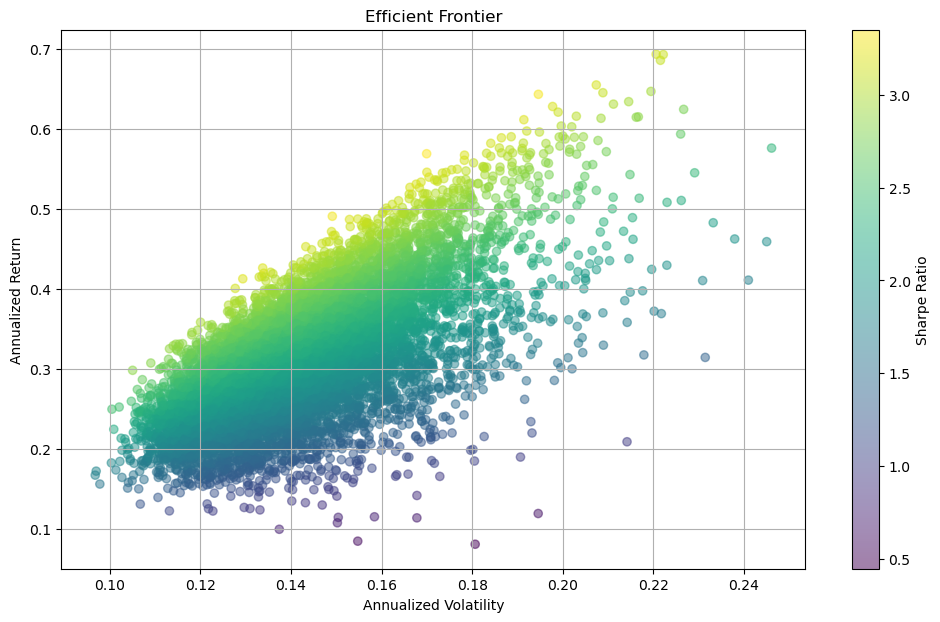

In [4]:
def efficient_frontier(num_portfolios=10000):
    """Generate random portfolios for frontier visualization"""
    weights = np.random.dirichlet(np.ones(num_assets), num_portfolios)
    returns = np.array([portfolio_return(w) for w in weights])
    volatilities = np.array([portfolio_volatility(w) for w in weights])
    return returns, volatilities

print("\nGenerating efficient frontier with 10,000 random portfolios...")
ef_returns, ef_volatilities = efficient_frontier()

# Plot frontier
plt.figure(figsize=(12, 7))
plt.scatter(ef_volatilities, ef_returns, c=ef_returns/ef_volatilities, 
            marker='o', cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.show()

### 11.4 Maximum Sharpe Ratio Portfolio

In [5]:
def max_sharpe_ratio(risk_free_rate=0.02):
    """Optimize for best risk-adjusted return"""
    def neg_sharpe_ratio(weights):
        return -(portfolio_return(weights) - risk_free_rate) / portfolio_volatility(weights)
    
    result = minimize(neg_sharpe_ratio,
                     num_assets*[1./num_assets],
                     method='SLSQP',
                     bounds=bounds,
                     constraints=constraints)
    return result.x

max_sharpe_weights = max_sharpe_ratio()
ret_max_sharpe = portfolio_return(max_sharpe_weights)
vol_max_sharpe = portfolio_volatility(max_sharpe_weights)

print("\nMaximum Sharpe Ratio Portfolio:")
print("Ideal for growth-oriented investors willing to accept")
print("higher risk for potentially greater returns over time")
print(f"Expected Return: {ret_max_sharpe:.2%}")
print(f"Volatility: {vol_max_sharpe:.2%}")


Maximum Sharpe Ratio Portfolio:
Ideal for growth-oriented investors willing to accept
higher risk for potentially greater returns over time
Expected Return: 57.67%
Volatility: 15.31%


### 11.5 Minimum Variance Portfolio

In [6]:
def min_variance_portfolio():
    """Optimize for lowest possible risk"""
    def portfolio_variance(weights):
        return portfolio_volatility(weights) ** 2
    
    result = minimize(portfolio_variance,
                     num_assets*[1./num_assets],
                     method='SLSQP',
                     bounds=bounds,
                     constraints=constraints)
    return result.x

min_var_weights = min_variance_portfolio()
ret_min_var = portfolio_return(min_var_weights)
vol_min_var = portfolio_volatility(min_var_weights)

print("\nMinimum Variance Portfolio:")
print("Ideal for conservative investors prioritizing")
print("capital preservation over growth potential")
print(f"Expected Return: {ret_min_var:.2%}")
print(f"Volatility: {vol_min_var:.2%}")


Minimum Variance Portfolio:
Ideal for conservative investors prioritizing
capital preservation over growth potential
Expected Return: 17.78%
Volatility: 9.25%


**Note:** *SLSQP* stands for Sequential Least Squares Programming. It's an optimization algorithm used to solve constrained nonlinear optimization problems.   

### 11.6 Visualization and Comparison

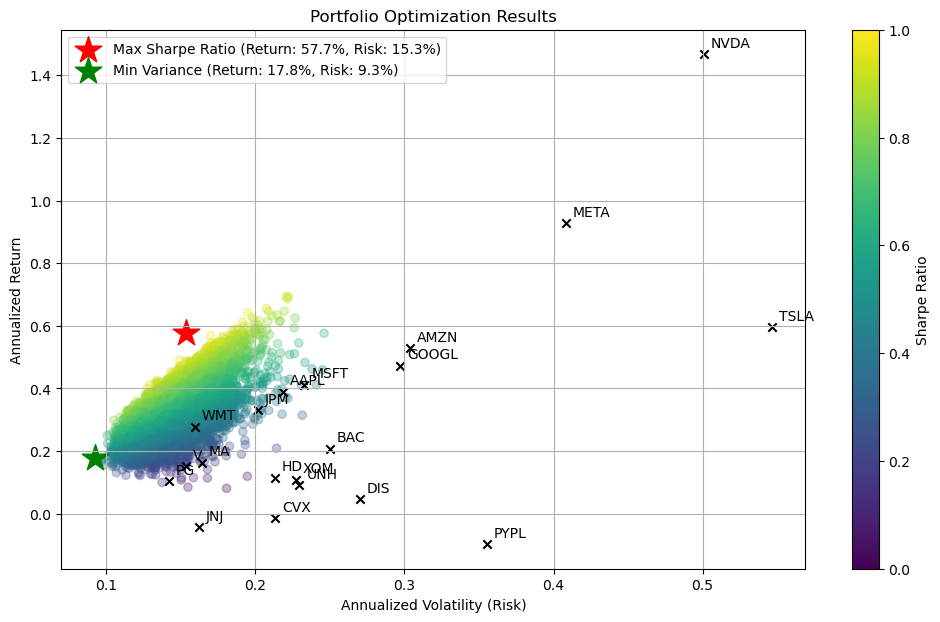

In [7]:
if 'returns' not in locals():
    returns = price_data.pct_change().dropna()

# Calculate annualized metrics for individual assets
asset_returns = returns.mean() * 252  # Annualized returns
asset_volatilities = returns.std() * np.sqrt(252)  # Annualized volatility

# Generate efficient frontier if not already done
if 'ef_returns' not in locals() or 'ef_volatilities' not in locals():
    ef_returns, ef_volatilities = efficient_frontier()

# Calculate optimal portfolios if not already done
if 'max_sharpe_weights' not in locals():
    max_sharpe_weights = max_sharpe_ratio()
    ret_max_sharpe = portfolio_return(max_sharpe_weights)
    vol_max_sharpe = portfolio_volatility(max_sharpe_weights)

if 'min_var_weights' not in locals():
    min_var_weights = min_variance_portfolio()
    ret_min_var = portfolio_return(min_var_weights)
    vol_min_var = portfolio_volatility(min_var_weights)

# Now create the plot with all required variables defined
plt.figure(figsize=(12, 7))

# Plot efficient frontier
plt.scatter(ef_volatilities, ef_returns, 
            c=ef_returns/ef_volatilities, 
            marker='o', alpha=0.3, cmap='viridis')

# Plot optimal portfolios
plt.scatter(vol_max_sharpe, ret_max_sharpe,
            marker='*', color='red', s=400,
            label=f'Max Sharpe Ratio (Return: {ret_max_sharpe:.1%}, Risk: {vol_max_sharpe:.1%})')
plt.scatter(vol_min_var, ret_min_var,
            marker='*', color='green', s=400,
            label=f'Min Variance (Return: {ret_min_var:.1%}, Risk: {vol_min_var:.1%})')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(asset_volatilities[i], asset_returns[i], 
               marker='x', color='black')
    plt.annotate(ticker, (asset_volatilities[i], asset_returns[i]),
                 xytext=(5,5), textcoords='offset points')

plt.title('Portfolio Optimization Results')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.legend()
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

### 11.7 Portfolio Composition Analysis

In [8]:
def analyze_portfolio(weights, name):
    """Display detailed portfolio analysis"""
    print(f"\n{name} Portfolio Composition:")
    print("-"*40)
    
    # Sort assets by weight
    sorted_assets = sorted(zip(tickers, weights), 
                      key=lambda x: x[1], reverse=True)
    
    # Print top holdings
    for ticker, weight in sorted_assets[:5]:
        print(f"{ticker}: {weight:.1%}")
    
    # Print statistics
    ret = portfolio_return(weights)
    vol = portfolio_volatility(weights)
    sharpe = (ret - 0.02)/vol
    
    print("\nKey Statistics:")
    print(f"Expected Return: {ret:.2%}")
    print(f"Expected Volatility: {vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    
    # Risk-return assessment
    if sharpe > 1.0:
        print("\nAssessment: Strong risk-adjusted returns")
    elif sharpe > 0.5:
        print("\nAssessment: Moderate risk-adjusted returns")
    else:
        print("\nAssessment: Weak risk-adjusted returns")

# Analyze both portfolios
analyze_portfolio(max_sharpe_weights, "Maximum Sharpe Ratio")
analyze_portfolio(min_var_weights, "Minimum Variance")


Maximum Sharpe Ratio Portfolio Composition:
----------------------------------------
WMT: 35.4%
NVDA: 20.3%
JPM: 14.4%
META: 11.0%
UNH: 7.7%

Key Statistics:
Expected Return: 57.67%
Expected Volatility: 15.31%
Sharpe Ratio: 3.64

Assessment: Strong risk-adjusted returns

Minimum Variance Portfolio Composition:
----------------------------------------
PG: 20.7%
JNJ: 17.1%
WMT: 15.4%
V: 8.7%
UNH: 7.1%

Key Statistics:
Expected Return: 17.78%
Expected Volatility: 9.25%
Sharpe Ratio: 1.71

Assessment: Strong risk-adjusted returns


## Summary 

This chapter explores portfolio optimization, enabling investors to build diversified portfolios that balance risk and return effectively. Using real-world financial data from the Tiingo API, we focus on calculating expected returns, the covariance matrix, and constructing the **Efficient Frontier**—a graphical representation of optimal portfolios that offer the highest return for a given level of risk.